# Kaggle設置

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read env var
!pip install python-dotenv
import dotenv
import os

dotenv.load_dotenv("/content/drive/MyDrive/中興_人工智慧概論/HW_final/.env")
api_token = {"username":os.getenv("KAGGLE_USERNAME"),"key":os.getenv("KAGGLE_KEY")}

!pip install kaggle

import json

kaggle_path = os.path.expanduser("~/.kaggle")
os.makedirs(kaggle_path, exist_ok=True)

with open(os.path.join(kaggle_path, "kaggle.json"), "w") as f:
    json.dump(api_token, f)

os.chmod(os.path.join(kaggle_path, "kaggle.json"), 0o600)

In [ ]:
api_token["username"]

'johnnydo0730'

# 觀察模型

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
print("Trainable params:", np.sum([np.prod(v.shape) for v in base_model.trainable_weights]))

#base_model.trainable = False
for i, layer in enumerate(base_model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

Trainable params: 4007548
  0 | input_layer_1                            | trainable = True
  1 | rescaling_2                              | trainable = True
  2 | normalization_1                          | trainable = True
  3 | rescaling_3                              | trainable = True
  4 | stem_conv_pad                            | trainable = True
  5 | stem_conv                                | trainable = True
  6 | stem_bn                                  | trainable = True
  7 | stem_activation                          | trainable = True
  8 | block1a_dwconv                           | trainable = True
  9 | block1a_bn                               | trainable = True
 10 | block1a_activation                       | trainable = True
 11 | block1a_se_squeeze                       | trainable = True
 12 | block1a_se_reshape                       | trainable = True
 13 | block1a_se_reduce                        | trainable = True
 14 | block1a_se_expand                        | t

# 定義訓練流程之通用函數

## 載入套件

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.callbacks import ModelCheckpoint

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
# use the model you want
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input

## 定義Dataloader

In [ ]:
def get_dataloader(train_dir, preprocess_input=None, img_size=(224, 224), batch_size=32):

  # 定義dataloader，使用資料增強（Data Augmentation）
  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,  # 隨機錯切
      zoom_range=0.2,   # 隨機縮放
      horizontal_flip=True,  # 水平翻轉
      rotation_range=20,  # 隨機旋轉
      fill_mode='nearest',  # 填補模式
      validation_split=0.2
  )

  train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical', # categorical
      subset='training'
  )

  val_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=img_size,
      batch_size=batch_size,
      class_mode='categorical',
      subset='validation'
  )

  return train_generator, val_generator


## 定義與編譯模型架構

| 模型             | 特徵圖輸出形狀 (before GAP) | GAP後形狀 (Dense輸入) |
| -------------- | -------------------- | ---------------- |
| VGG19          | (7, 7, 512)          | (512,)           |
| ResNet50       | (7, 7, 2048)         | (2048,)          |
| EfficientNetB0 | (7, 7, 1280)         | (1280,)          |


In [ ]:

def build_model_with_head(base_model, num_classes):
    """
    接收一個 base_model 並接上分類頭，回傳已編譯的模型。

    參數：
        base_model: 已經定義好輸入的預訓練模型（如 VGG19、ResNet50、EfficientNet）
        num_classes: 分類數（1 代表二分類，多類分類請傳整數 >1）
        activation: 最後一層的 activation 函數，二分類用 'sigmoid'，多類用 'softmax'
        loss: 損失函數名稱 (sparse_categorical_crossentropy)

    回傳：
        尚未編譯的 keras.Model（需由使用者自行 compile）
    """

    if num_classes < 1:
      raise ValueError("num_classes 必須 >= 1")

    #activation = 'sigmoid' if num_classes == 1 else 'softmax'
    activation = 'softmax'

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    output_tensor = layers.Dense(num_classes, activation=activation)(x)

    model = tf.keras.models.Model(inputs=base_model.input, outputs=output_tensor)

    return model

## callback tools

In [ ]:
import pickle
import os

class HistorySaver(tf.keras.callbacks.Callback):
    def __init__(self, save_path):
        super().__init__()
        self.save_path = save_path
        self.history = {}

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

In [ ]:
from keras.callbacks import ReduceLROnPlateau
'''
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)
'''

"\nlr_scheduler = ReduceLROnPlateau(\n    monitor='val_loss',\n    factor=0.5,\n    patience=2,\n    min_lr=1e-7,\n    verbose=1\n)\n"

## 定義訓練函數

In [ ]:
def train_model_with_gpu_check(model, train_generator, val_generator, lr, epochs, save_dir, phase, lr_scheduler=None):
    """
    檢查 GPU 可用性並訓練模型，儲存最佳模型。

    參數：
        model: 已經編譯好的模型。
        train_generator: 訓練數據生成器（如 ImageDataGenerator 生成器）。
        val_generator: 驗證數據生成器（如 ImageDataGenerator 生成器）。
        epochs: 訓練的輪數（預設為 5）。
        save_dir: 儲存模型的資料夾（預設為 'models'）。
        phase: 訓練階段（'phase1' 或 'phase2'）

    回傳：
        history: 訓練過程的歷史紀錄。
    """

    # 檢查是否有可用的 GPU
    gpus = tf.config.list_physical_devices('GPU')
    #if len(gpus) == 0:
        #raise Exception("No GPU available, stop traing process")
    print("Num GPUs Available: ", len(gpus))

    #loss = 'binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy'
    loss = 'categorical_crossentropy'
    model.compile(optimizer=optimizers.Adam(learning_rate=lr), loss=loss, metrics=['accuracy'])

    # 設定儲存中間資訊
    checkpoint = ModelCheckpoint(os.path.join(save_dir, phase + '_best_model.keras'), monitor='val_loss', save_best_only=True)
    history_saver = HistorySaver(os.path.join(save_dir, phase + '_history.pkl'))

    # 預設 learning rate scheduler
    callbacks = [checkpoint, history_saver]
    if lr_scheduler is not None:
        callbacks.append(lr_scheduler)

    # 訓練模型
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

## 視覺化呈現

In [ ]:
def plot_learning_curve_with_split(history, save_dir, phase):
    """
    根據 keras 的 history 物件繪製並儲存學習曲線。
    儲存三張圖：合併版、acc 單獨圖、loss 單獨圖。

    參數：
        history: keras.callbacks.History（model.fit() 的回傳結果）
        save_dir: 儲存圖像的資料夾（預設為 'output'）
    """
    os.makedirs(save_dir, exist_ok=True)

    # 1. 合併版
    plt.figure(figsize=(12, 5))

    # Accuracy subplot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))

    # Loss subplot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, phase + '_learning_curve.png'))
    plt.show()

    # 2. Accuracy 單獨
    plt.figure()
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['accuracy'])))
    plt.savefig(os.path.join(save_dir, phase + '_accuracy_curve.png'))
    #plt.show()

    # 3. Loss 單獨
    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(False)
    plt.xticks(range(len(history.history['loss'])))
    plt.savefig(os.path.join(save_dir, phase + '_loss_curve.png'))
    #plt.show()


## 保存模型

In [ ]:
import os

def save_model(model, save_dir, filename):
    """
    儲存 Keras 模型為指定格式（支援 .keras 或 .h5）

    參數：
        model: 已訓練的 Keras 模型
        filename: 儲存檔名（預設為 'model.keras'）
        save_dir: 儲存資料夾（預設為 'models'）
    """
    os.makedirs(save_dir, exist_ok=True)
    full_path = os.path.join(save_dir, filename)
    model.save(full_path)
    print(f"✅ 模型已儲存至 {full_path}")


#FER plus

    use phase 3 best

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download subhaditya/fer2013plus
!unzip /content/fer2013plus.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: fer2013plus/fer2013/train/sadness/fer0017536.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017542.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017574.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017577.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017579.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017584.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017610.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017616.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017623.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017633.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017649.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017669.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017671.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017676.png  
  inflating: fer2013plus/fer2013/train/sadness/fer0017679.png  
  inflating: fer201

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

'''
# 把灰階轉成 RGB 並使用 keras 的 preprocess_input
def custom_preprocessing(img):
    # 將 numpy 陣列轉為 Tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # 若是灰階（只有1個通道），轉成 RGB
    if img_tensor.shape[-1] == 1:
        img_tensor = tf.image.grayscale_to_rgb(img_tensor)

    # 再轉回 numpy 並套用 Keras 的預處理（如：ResNet50 的預處理）
    img_rgb = img_tensor.numpy()
    img_rgb = preprocess_input(img_rgb)

    return img_rgb
'''

def get_FERplus_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=validation_split
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

def get_FERplus_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
num_classes = 8
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FERplus"

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 397s 511ms/step - accuracy: 0.3980 - loss: 1.5792 - val_accuracy: 0.5857 - val_loss: 1.1673
Epoch 2/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 317s 444ms/step - accuracy: 0.5795 - loss: 1.1855 - val_accuracy: 0.6454 - val_loss: 1.0001
Epoch 3/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 323s 446ms/step - accuracy: 0.6274 - loss: 1.0437 - val_accuracy: 0.6685 - val_loss: 0.9310
Epoch 4/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 315s 444ms/step - accuracy: 0.6683 - loss: 0.9453 - val_accuracy: 0.6951 - val_loss: 0.8805
Epoch 5/5
710/710 ━━━━━━━━━━━━━━━━━━━━ 316s 445ms/step - accuracy: 0.6798 - loss: 0.9116 - val_accuracy: 0.7080 - val_loss: 0.8261


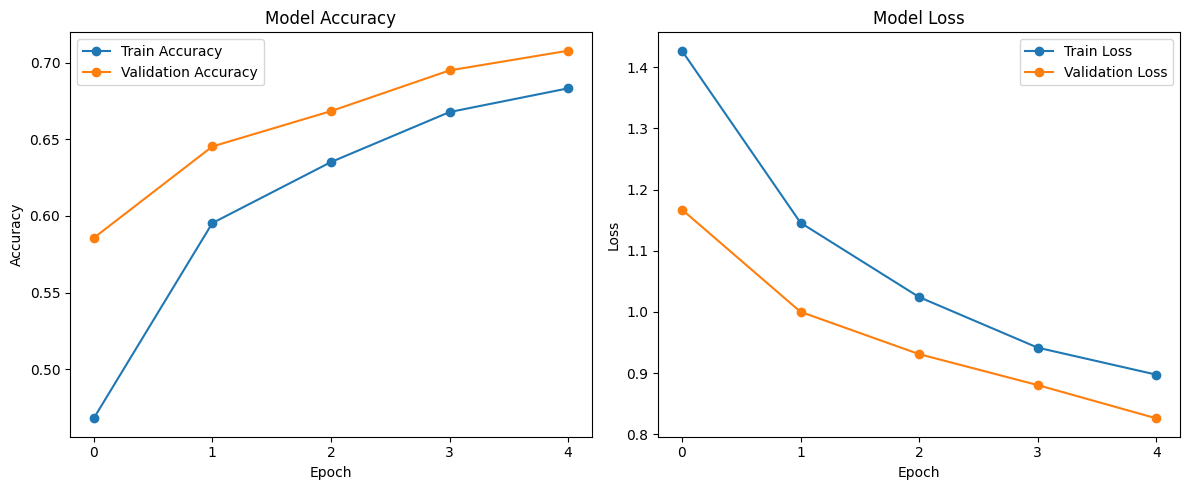

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FERplus/EfficientNetB0_FERplus_phase1.keras


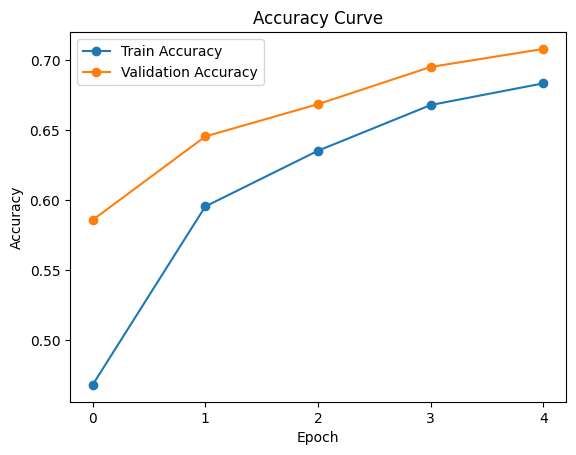

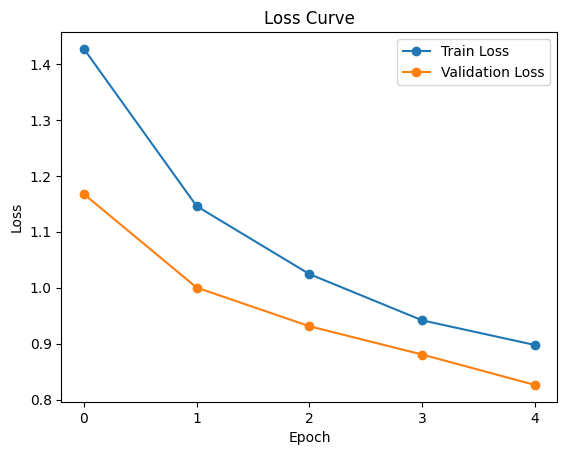

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True  # 凍結卷積層
for layer in base_model.layers[:222]: # 222 | block7a_expand_conv
    layer.trainable = False
for layer in base_model.layers[222:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_FERplus_" + phase + ".keras")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1
Epoch 1/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 375s 489ms/step - accuracy: 0.7019 - loss: 0.8538 - val_accuracy: 0.7198 - val_loss: 0.7829 - learning_rate: 1.0000e-05
Epoch 2/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 319s 449ms/step - accuracy: 0.7112 - loss: 0.8208 - val_accuracy: 0.7272 - val_loss: 0.7705 - learning_rate: 1.0000e-05
Epoch 3/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 319s 449ms/step - accuracy: 0.7177 - loss: 0.7996 - val_accuracy: 0.7305 - val_loss: 0.7647 - learning_rate: 1.0000e-05
Epoch 4/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 320s 451ms/step - accuracy: 0.7187 - loss: 0.7881 - val_accuracy: 0.7282 - val_loss: 0.7522 - learning_rate: 1.0000e-05
Epoch 5/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 318s 448ms/step - accuracy: 0.7241 - loss: 0.7821 - val_accuracy: 0.7291 - val_loss: 0.7472 - learning_rate: 1.0000e-05
Epoch 6/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 319s 449ms/step - accuracy: 0.7269 - loss: 0.7640 - 

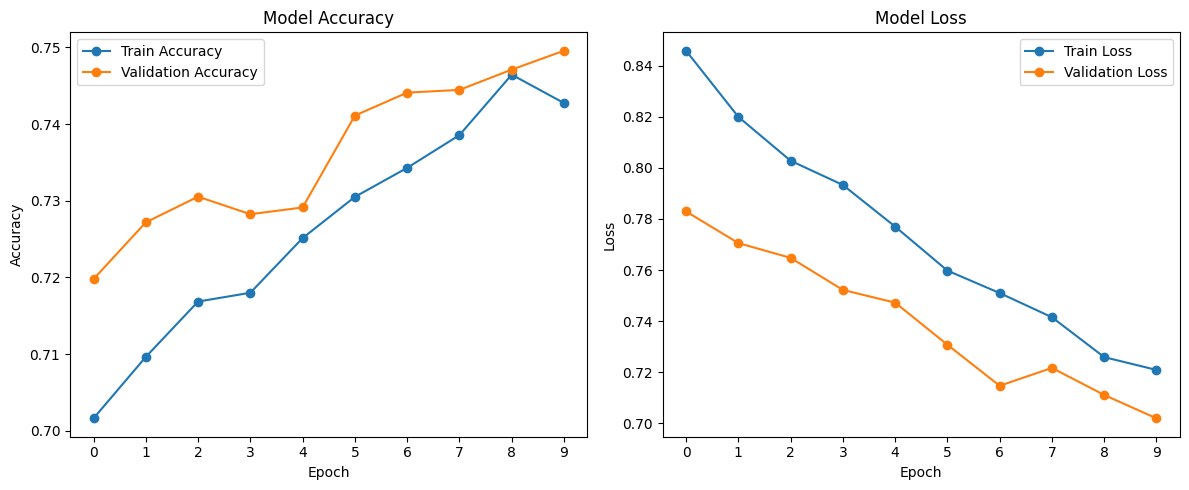

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FERplus/EfficientNetB0_FERplus_phase2.keras


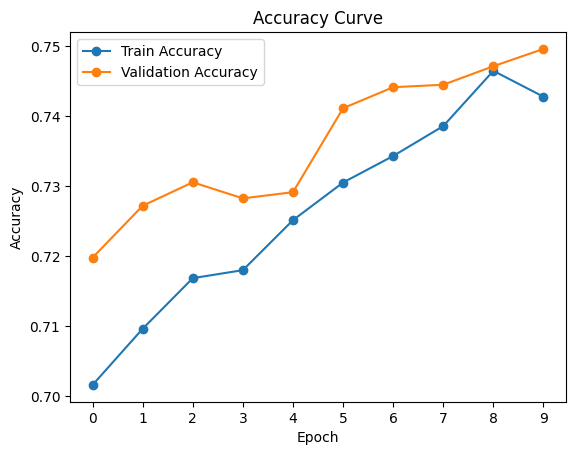

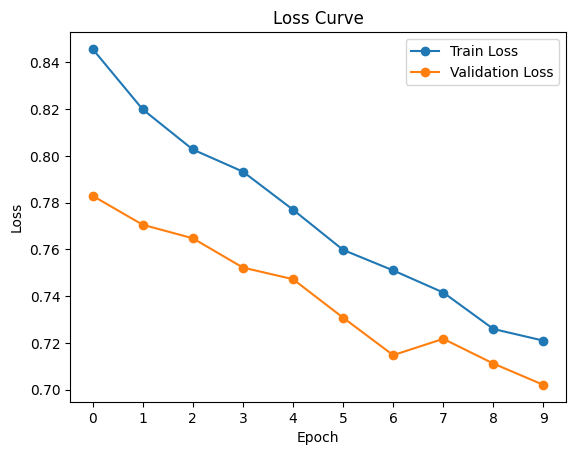

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/EfficientNetB0_FERplus_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:163]:  # 163 | block6a_expand_conv
    layer.trainable = False
for layer in model.layers[163:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_FERplus_" + phase + ".keras")

Found 22712 images belonging to 8 classes.
Found 5674 images belonging to 8 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 421s 540ms/step - accuracy: 0.7556 - loss: 0.6980 - val_accuracy: 0.7541 - val_loss: 0.6819 - learning_rate: 1.0000e-05
Epoch 2/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 349s 491ms/step - accuracy: 0.7554 - loss: 0.6876 - val_accuracy: 0.7587 - val_loss: 0.6721 - learning_rate: 1.0000e-05
Epoch 3/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 345s 487ms/step - accuracy: 0.7607 - loss: 0.6737 - val_accuracy: 0.7587 - val_loss: 0.6627 - learning_rate: 1.0000e-05
Epoch 4/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 345s 487ms/step - accuracy: 0.7699 - loss: 0.6488 - val_accuracy: 0.7645 - val_loss: 0.6532 - learning_rate: 1.0000e-05
Epoch 5/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 380s 484ms/step - accuracy: 0.7676 - loss: 0.6582 - val_accuracy: 0.7716 - val_loss: 0.6386 - learning_rate: 1.0000e-05
Epoch 6/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 359s 506ms/step - accuracy: 0.7790 - loss: 0.6229 - val_accuracy: 0.7728 - val_loss: 0.6424 - learning_rate: 1.0000e-05
Epoch 7/10
710/710 ━━━━━━━━━━━━━━━━━━━━ 

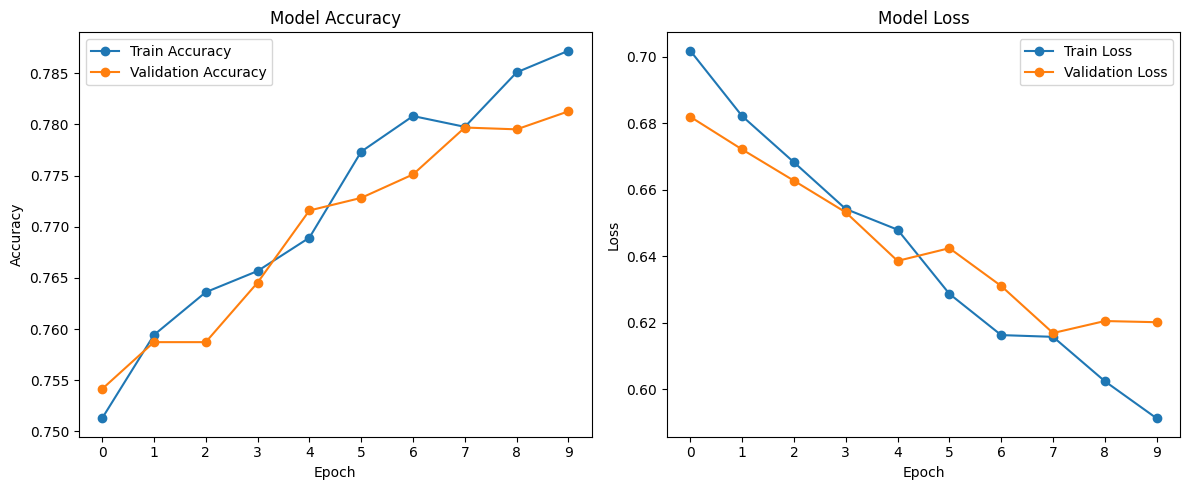

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FERplus/EfficientNetB0_FERplus_phase3.keras


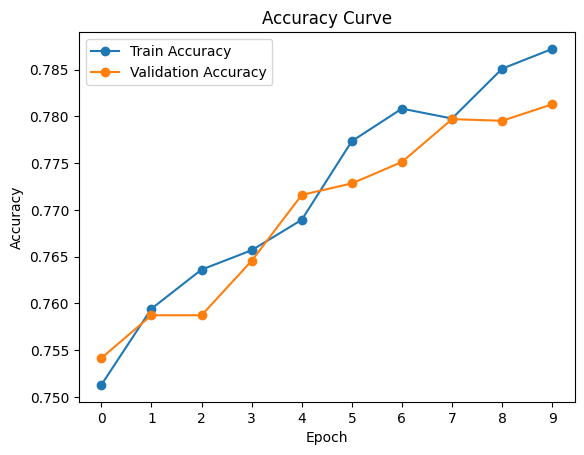

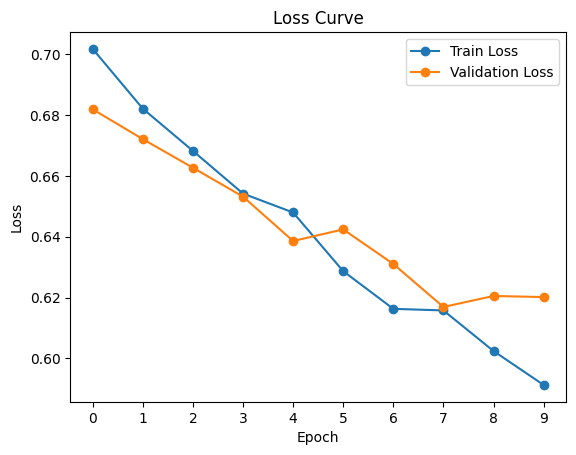

In [ ]:
# phase 3
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/EfficientNetB0_FERplus_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:120]:  # 120 | block5a_expand_conv
    layer.trainable = False
for layer in model.layers[120:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FERplus_trainloader('/content/fer2013plus/fer2013/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_FERplus_" + phase + ".keras")

# RAF-DB


    資料容易過擬合
    ➤ 高解析度 + 彩色照片 + 背景豐富 → 模型易學到非表情特徵（如背景、髮型）

    類別分布不均
    ➤ 快樂、中性樣本佔比極高，導致模型偏向多數類別 → 驗證集上泛化不佳
    
      訓練時模型過度學習多數類別，train acc 較高。
      驗證時少數類別預測失誤，拉低 val acc，造成 gap。

    訓練樣本較少
    ➤ RAF-DB 訓練集樣本比 FER+ 少 → 模型泛化能力下降，容易背誦

    驗證集難度較高
    ➤ 包含更多自然變化（角度、光線） → 驗證表現受影響

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download shuvoalok/raf-db-dataset
!unzip /content/raf-db-dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: DATASET/train/5/train_00987_aligned.jpg  
  inflating: DATASET/train/5/train_00990_aligned.jpg  
  inflating: DATASET/train/5/train_00991_aligned.jpg  
  inflating: DATASET/train/5/train_00992_aligned.jpg  
  inflating: DATASET/train/5/train_01002_aligned.jpg  
  inflating: DATASET/train/5/train_01010_aligned.jpg  
  inflating: DATASET/train/5/train_01011_aligned.jpg  
  inflating: DATASET/train/5/train_01013_aligned.jpg  
  inflating: DATASET/train/5/train_01015_aligned.jpg  
  inflating: DATASET/train/5/train_01017_aligned.jpg  
  inflating: DATASET/train/5/train_01039_aligned.jpg  
  inflating: DATASET/train/5/train_01048_aligned.jpg  
  inflating: DATASET/train/5/train_01049_aligned.jpg  
  inflating: DATASET/train/5/train_01053_aligned.jpg  
  inflating: DATASET/train/5/train_01070_aligned.jpg  
  inflating: DATASET/train/5/train_01074_aligned.jpg  
  inflating: DATASET/train/5/train_01078_aligned.jpg  
  inflating: DATASET/train/5/train_01083_ali

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_RAFDB_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    """
    用來載入訓練資料集並進行資料增強（data augmentation）。

    參數：
        train_dir (str): 訓練資料集的根目錄。
        img_size (tuple): 輸入影像大小。
        batch_size (int): 批次大小。
        validation_split (float): 用來分割訓練資料與驗證資料的比例。

    回傳：
        train_generator: 訓練資料生成器。
        val_generator: 驗證資料生成器。
    """

    # 定義資料增強
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,  # 隨機錯切
        zoom_range=0.2,   # 隨機縮放
        horizontal_flip=True,  # 水平翻轉
        rotation_range=20,  # 隨機旋轉
        fill_mode='nearest',  # 填補模式
        validation_split=validation_split  # 設定驗證集的比例
    )

    # 訓練集生成器
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  # 類別模式：多類別分類
        subset='training'  # 設定為訓練集
    )

    # 驗證集生成器
    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'  # 設定為驗證集
    )

    return train_generator, val_generator


In [ ]:
def get_RAFDB_testloader(test_dir, img_size=(224, 224), batch_size=32):
    """
    用來載入測試資料集。

    參數：
        test_dir (str): 測試資料集的根目錄。
        img_size (tuple): 輸入影像大小。
        batch_size (int): 批次大小。

    回傳：
        test_generator: 測試資料生成器。
    """

    # 定義資料增強（此處測試資料集只會預處理，不進行增強）
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # 測試集生成器
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',  # 類別模式：多類別分類
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
num_classes = 7
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/RAF-DB"

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 199s 547ms/step - accuracy: 0.3825 - loss: 1.6531 - val_accuracy: 0.5624 - val_loss: 1.2161
Epoch 2/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 143s 468ms/step - accuracy: 0.5402 - loss: 1.2750 - val_accuracy: 0.6419 - val_loss: 1.0172
Epoch 3/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 141s 460ms/step - accuracy: 0.5974 - loss: 1.0967 - val_accuracy: 0.6623 - val_loss: 0.9385
Epoch 4/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 144s 469ms/step - accuracy: 0.6386 - loss: 1.0050 - val_accuracy: 0.6876 - val_loss: 0.9001
Epoch 5/5
307/307 ━━━━━━━━━━━━━━━━━━━━ 155s 507ms/step - accuracy: 0.6670 - loss: 0.9305 - val_accuracy: 0.6945 - val_loss: 0.8561


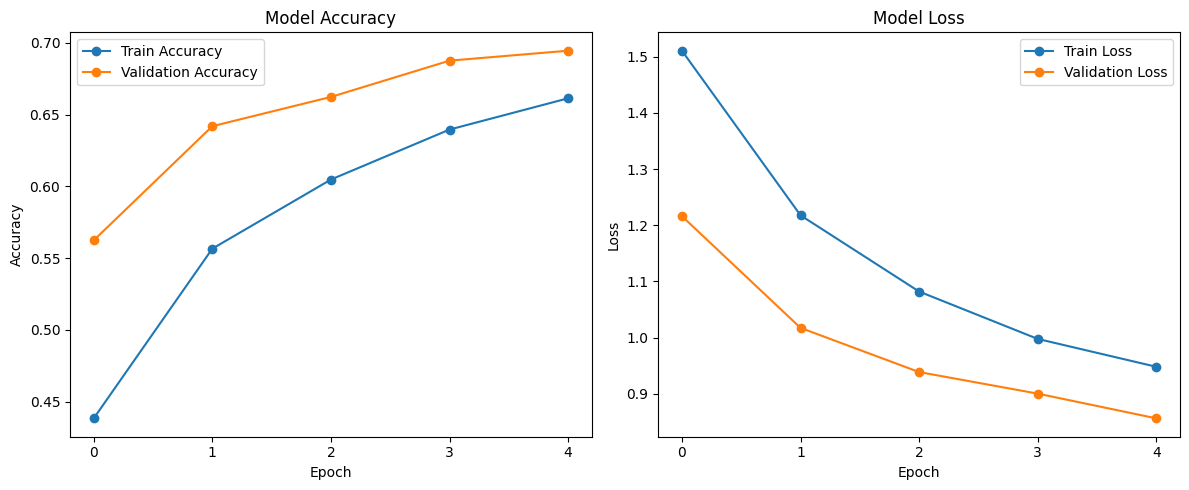

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/RAF-DB/EfficientNetB0_RAF-DB_phase1.keras


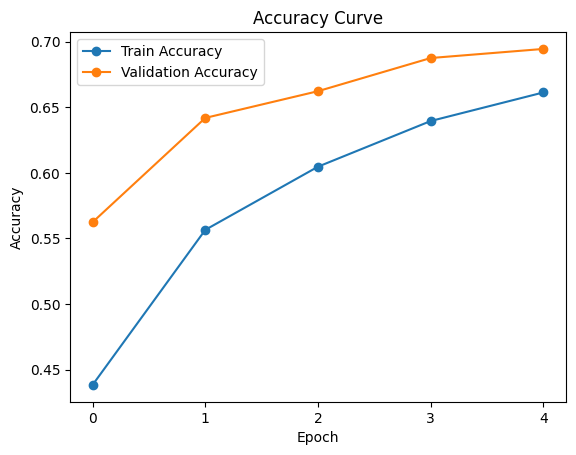

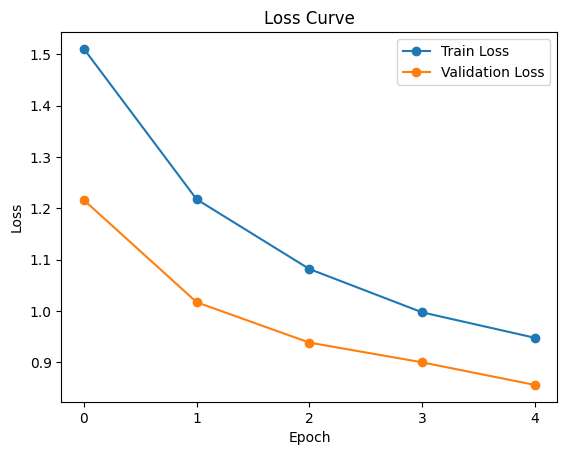

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True
for layer in base_model.layers[:222]: # 222 | block7a_expand_conv
    layer.trainable = False
for layer in base_model.layers[222:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_RAF-DB_" + phase + ".keras")

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1
Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 199s 553ms/step - accuracy: 0.6760 - loss: 0.8910 - val_accuracy: 0.7092 - val_loss: 0.8223 - learning_rate: 1.0000e-05
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 142s 462ms/step - accuracy: 0.6907 - loss: 0.8651 - val_accuracy: 0.7133 - val_loss: 0.8076 - learning_rate: 1.0000e-05
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 143s 467ms/step - accuracy: 0.6956 - loss: 0.8645 - val_accuracy: 0.7292 - val_loss: 0.7944 - learning_rate: 1.0000e-05
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 142s 463ms/step - accuracy: 0.6996 - loss: 0.8366 - val_accuracy: 0.7300 - val_loss: 0.7726 - learning_rate: 1.0000e-05
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 149s 484ms/step - accuracy: 0.7070 - loss: 0.8182 - val_accuracy: 0.7280 - val_loss: 0.7726 - learning_rate: 1.0000e-05
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 146s 476ms/step - accuracy: 0.7187 - loss: 0.7936 - v

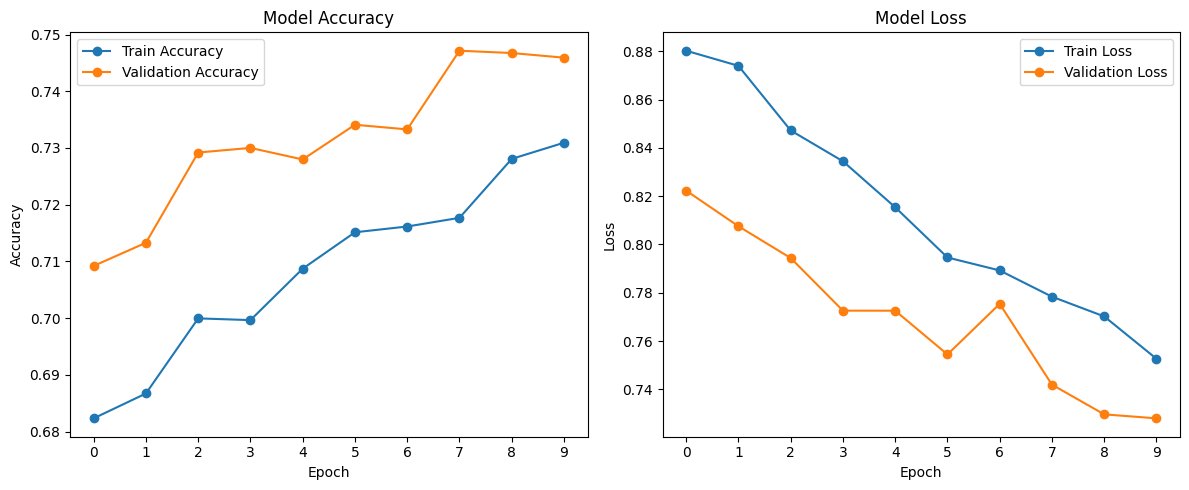

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/RAF-DB/EfficientNetB0_RAF-DB_phase2.keras


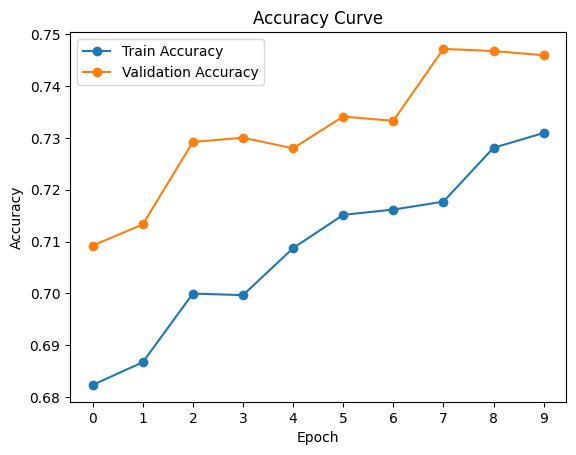

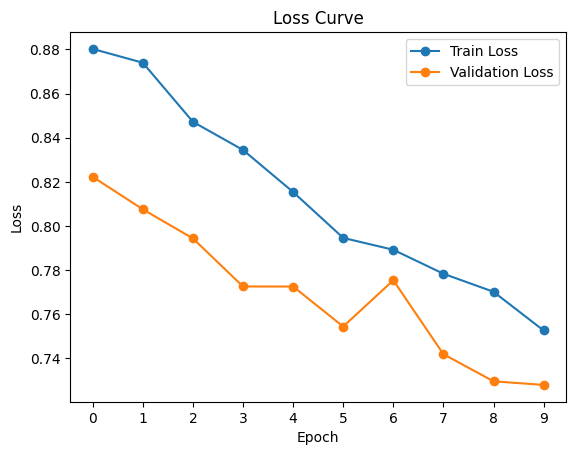

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)


# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/EfficientNetB0_RAF-DB_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:163]:  # 163 | block6a_expand_conv
    layer.trainable = False
for layer in model.layers[163:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_RAF-DB_" + phase + ".keras")

Found 9819 images belonging to 7 classes.
Found 2452 images belonging to 7 classes.
Num GPUs Available:  1
Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 206s 559ms/step - accuracy: 0.7266 - loss: 0.7446 - val_accuracy: 0.7447 - val_loss: 0.7296 - learning_rate: 1.0000e-05
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 146s 475ms/step - accuracy: 0.7363 - loss: 0.7414 - val_accuracy: 0.7610 - val_loss: 0.6961 - learning_rate: 1.0000e-05
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 160s 522ms/step - accuracy: 0.7487 - loss: 0.7030 - val_accuracy: 0.7622 - val_loss: 0.6949 - learning_rate: 1.0000e-05
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 148s 481ms/step - accuracy: 0.7482 - loss: 0.6955 - val_accuracy: 0.7614 - val_loss: 0.6911 - learning_rate: 1.0000e-05
Epoch 5/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 149s 484ms/step - accuracy: 0.7514 - loss: 0.6899 - val_accuracy: 0.7651 - val_loss: 0.6742 - learning_rate: 1.0000e-05
Epoch 6/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 158s 515ms/step - accuracy: 0.7641 - loss: 0.6635 - v

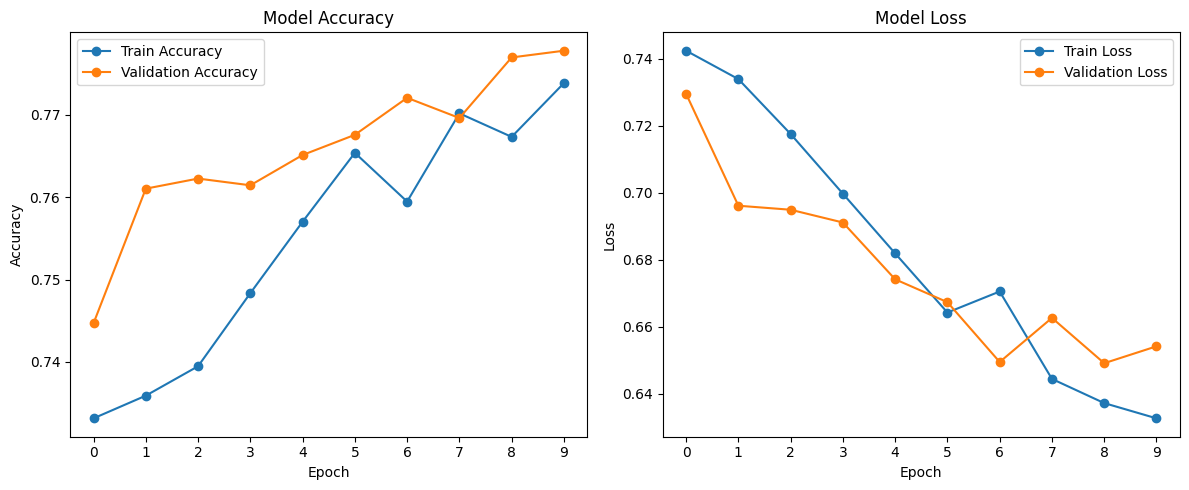

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/RAF-DB/EfficientNetB0_RAF-DB_phase3.keras


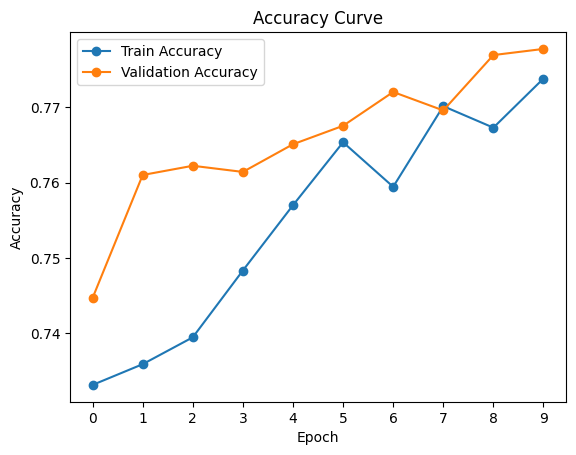

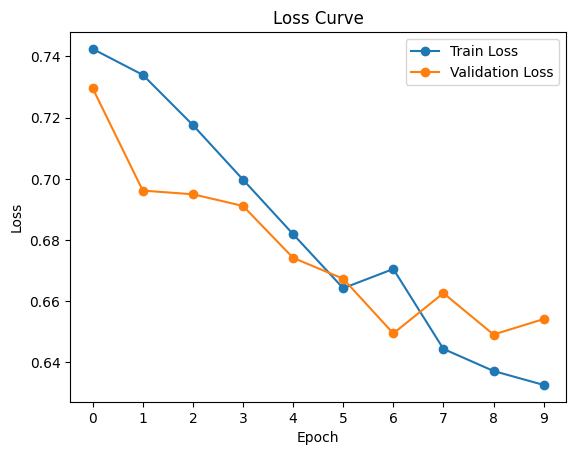

In [ ]:
# phase 3
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/EfficientNetB0_RAF-DB_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:120]:  # 120 | block5a_expand_conv
    layer.trainable = False
for layer in model.layers[120:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_RAFDB_trainloader('/content/DATASET/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_RAF-DB_" + phase + ".keras")

#FER 2013

## 下載資料

In [ ]:
#!/bin/bash
!kaggle datasets download msambare/fer2013
!unzip /content/fer2013.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating: train/sad/Training_65526454.

## 定義Dataloader

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np

'''
# 把灰階轉成 RGB 並使用 keras 的 preprocess_input
def custom_preprocessing(img):
    # 將 numpy 陣列轉為 Tensor
    img_tensor = tf.convert_to_tensor(img, dtype=tf.float32)

    # 若是灰階（只有1個通道），轉成 RGB
    if img_tensor.shape[-1] == 1:
        img_tensor = tf.image.grayscale_to_rgb(img_tensor)

    # 再轉回 numpy 並套用 Keras 的預處理（如：ResNet50 的預處理）
    img_rgb = img_tensor.numpy()
    img_rgb = preprocess_input(img_rgb)

    return img_rgb
'''

def get_FER2013_trainloader(train_dir, img_size=(224, 224), batch_size=32, validation_split=0.2):
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='nearest',
        validation_split=validation_split
    )

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'
    )

    val_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        #color_mode='grayscale',
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'
    )

    return train_generator, val_generator

def get_FER2013_testloader(test_dir, img_size=(224, 224), batch_size=32):
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        #color_mode='grayscale',  # 讀入灰階
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return test_generator


## 訓練

In [ ]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
num_classes = 7
save_dir = "/content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FER2013"

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1
Epoch 1/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 394s 515ms/step - accuracy: 0.2834 - loss: 1.7672 - val_accuracy: 0.4281 - val_loss: 1.4778
Epoch 2/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 339s 472ms/step - accuracy: 0.4251 - loss: 1.5053 - val_accuracy: 0.4788 - val_loss: 1.3557
Epoch 3/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 340s 474ms/step - accuracy: 0.4714 - loss: 1.3871 - val_accuracy: 0.5111 - val_loss: 1.2900
Epoch 4/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 341s 475ms/step - accuracy: 0.4962 - loss: 1.3292 - val_accuracy: 0.5236 - val_loss: 1.2527
Epoch 5/5
718/718 ━━━━━━━━━━━━━━━━━━━━ 343s 477ms/step - accuracy: 0.5237 - loss: 1.2608 - val_accuracy: 0.5358 - val_loss: 1.2173


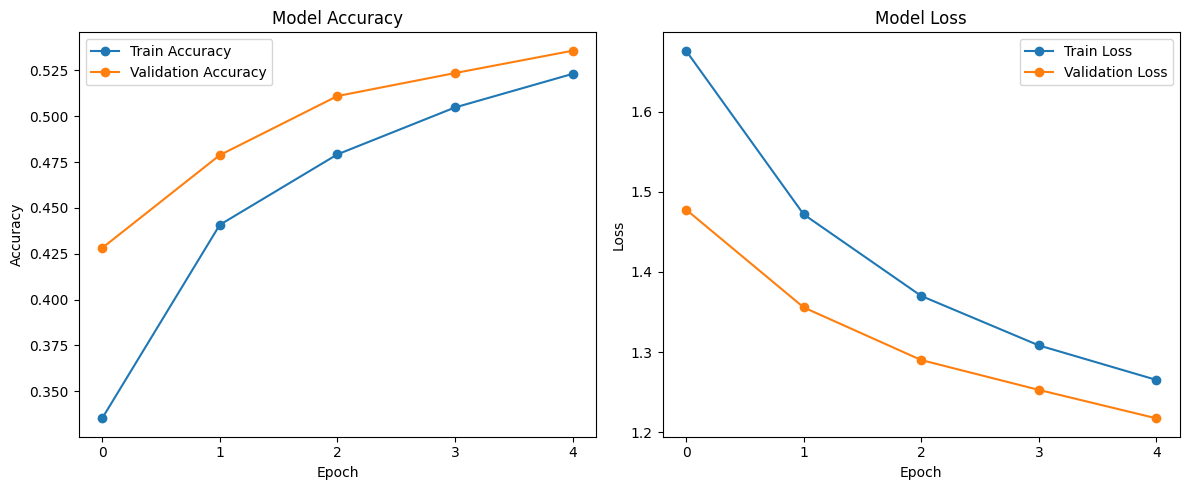

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FER2013/EfficientNetB0_FER2013_phase1.keras


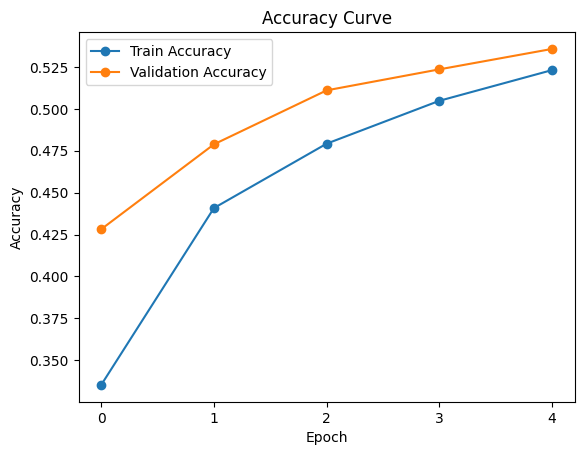

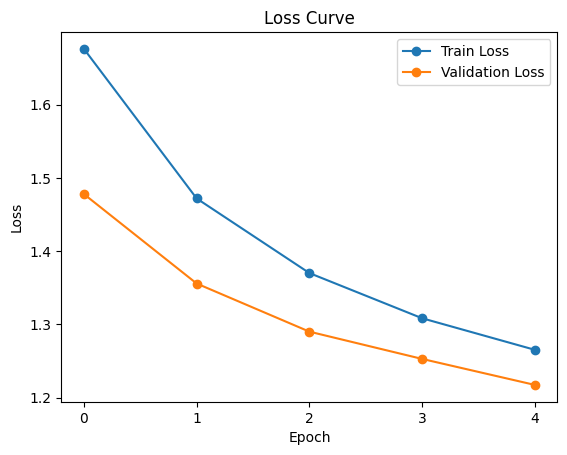

In [ ]:
# phase 1
lr = 1e-4
epochs = 5
batch_size = 32
phase = 'phase1'

base_model.trainable = True  # 凍結卷積層
for layer in base_model.layers[:222]: # 222 | block7a_expand_conv
    layer.trainable = False
for layer in base_model.layers[222:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
model = build_model_with_head(base_model, num_classes)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_FER2013_" + phase + ".keras")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 412s 519ms/step - accuracy: 0.5354 - loss: 1.2269 - val_accuracy: 0.5436 - val_loss: 1.1845 - learning_rate: 1.0000e-05
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 338s 471ms/step - accuracy: 0.5484 - loss: 1.1972 - val_accuracy: 0.5541 - val_loss: 1.1622 - learning_rate: 1.0000e-05
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 339s 472ms/step - accuracy: 0.5538 - loss: 1.1810 - val_accuracy: 0.5525 - val_loss: 1.1612 - learning_rate: 1.0000e-05
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 342s 476ms/step - accuracy: 0.5568 - loss: 1.1818 - val_accuracy: 0.5614 - val_loss: 1.1532 - learning_rate: 1.0000e-05
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 336s 468ms/step - accuracy: 0.5598 - loss: 1.1646 - val_accuracy: 0.5656 - val_loss: 1.1442 - learning_rate: 1.0000e-05
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 338s 470ms/step - accuracy: 0.5648 - loss: 1.1482 - val_accuracy: 0.5712 - val_loss: 1.1340 - learning_rate: 1.0000e-05
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 

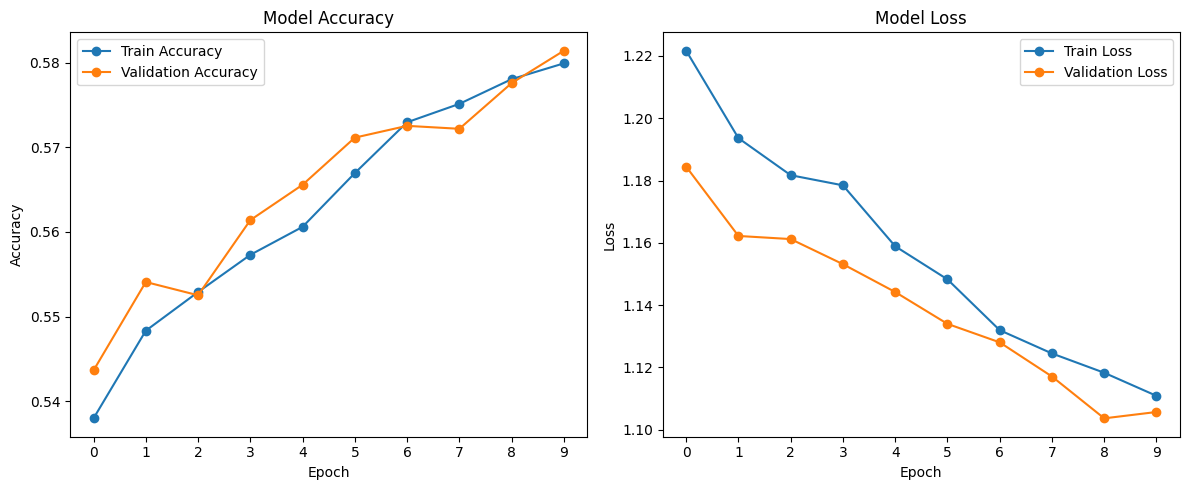

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FER2013/EfficientNetB0_FER2013_phase2.keras


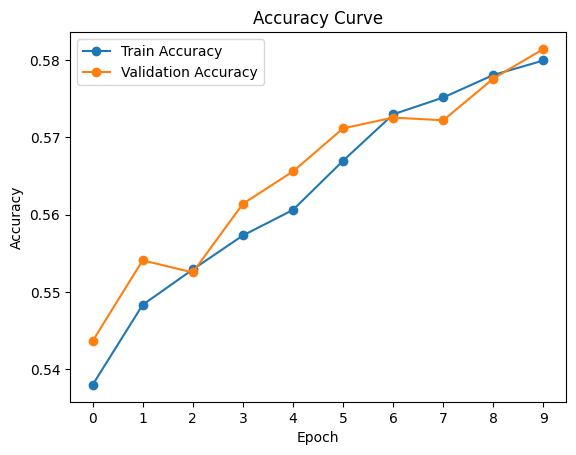

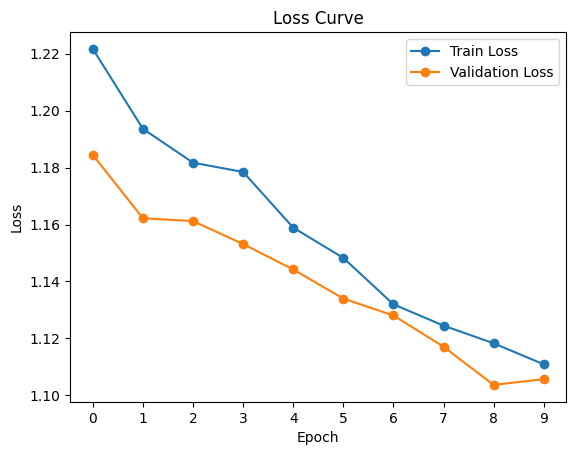

In [ ]:
# phase 2
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase2'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/EfficientNetB0_FER2013_phase1.keras", compile=False)

model.trainable = True
for layer in model.layers[:163]:  # 163 | block6a_expand_conv
    layer.trainable = False
for layer in model.layers[163:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_FER2013_" + phase + ".keras")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Num GPUs Available:  1


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 415s 524ms/step - accuracy: 0.5866 - loss: 1.0999 - val_accuracy: 0.5818 - val_loss: 1.0939 - learning_rate: 1.0000e-05
Epoch 2/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 343s 477ms/step - accuracy: 0.5983 - loss: 1.0756 - val_accuracy: 0.5846 - val_loss: 1.0868 - learning_rate: 1.0000e-05
Epoch 3/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 359s 500ms/step - accuracy: 0.6032 - loss: 1.0590 - val_accuracy: 0.5933 - val_loss: 1.0807 - learning_rate: 1.0000e-05
Epoch 4/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 347s 484ms/step - accuracy: 0.6030 - loss: 1.0538 - val_accuracy: 0.5943 - val_loss: 1.0669 - learning_rate: 1.0000e-05
Epoch 5/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 354s 493ms/step - accuracy: 0.5968 - loss: 1.0580 - val_accuracy: 0.6009 - val_loss: 1.0480 - learning_rate: 1.0000e-05
Epoch 6/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 377s 487ms/step - accuracy: 0.6130 - loss: 1.0367 - val_accuracy: 0.6093 - val_loss: 1.0457 - learning_rate: 1.0000e-05
Epoch 7/10
718/718 ━━━━━━━━━━━━━━━━━━━━ 

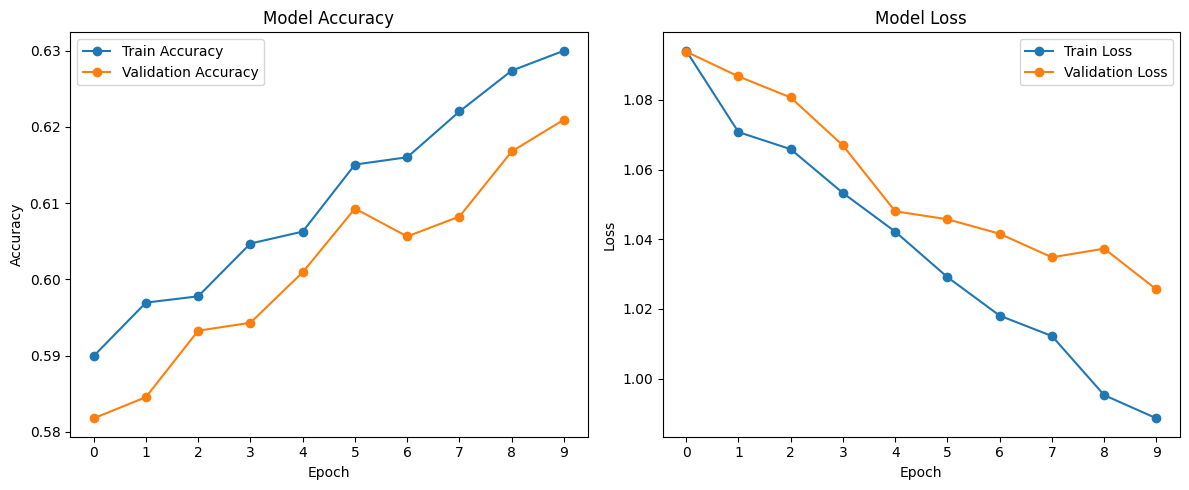

✅ 模型已儲存至 /content/drive/MyDrive/中興_人工智慧概論/HW_final/EfficientNetB0/FER2013/EfficientNetB0_FER2013_phase3.keras


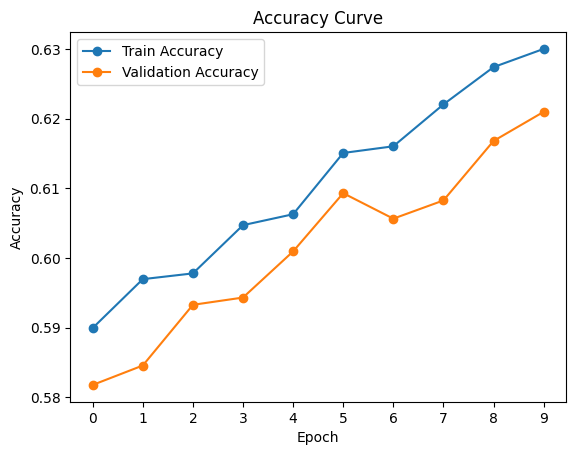

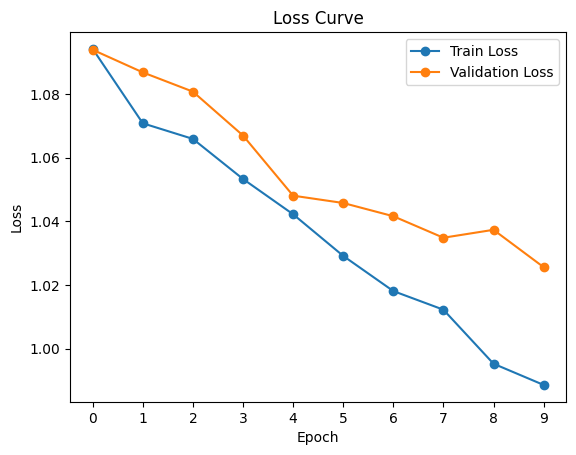

In [ ]:
# phase 3
lr = 1e-5
epochs = 10
batch_size = 32
phase = 'phase3'

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-7,
    verbose=1
)



# 載入第一階段訓練的模型並解凍層
model = models.load_model(save_dir + "/EfficientNetB0_FER2013_phase2.keras", compile=False)

model.trainable = True
for layer in model.layers[:120]:  # 120 | block5a_expand_conv
    layer.trainable = False
for layer in model.layers[120:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

train_ds, val_ds = get_FER2013_trainloader('/content/train', batch_size=batch_size)
history = train_model_with_gpu_check(model, train_ds, val_ds, lr, epochs, save_dir, phase, lr_scheduler=lr_scheduler)
plot_learning_curve_with_split(history, save_dir, phase)
save_model(model, save_dir, "EfficientNetB0_FER2013_" + phase + ".keras")

# 新增區段

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers
import numpy as np

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
print("Trainable params:", np.sum([np.prod(v.shape) for v in base_model.trainable_weights]))

base_model.trainable = False
#base_model.trainable = False
for i, layer in enumerate(base_model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

In [ ]:
model = build_model_with_head(base_model, 7)
for i, layer in enumerate(model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")

In [ ]:
for layer in base_model.layers[165:]:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True


for i, layer in enumerate(model.layers):
    print(f"{i:3d} | {layer.name:40s} | trainable = {layer.trainable}")